# Multivariate statistics (decoding / MVPA) on MEG/EEG

Author : Alexandre Gramfort

In [1]:
# add plot inline in the page
%matplotlib inline
import matplotlib.pyplot as plt

First, load the mne package:

In [2]:
import mne

We set the log-level to 'WARNING' so the output is less verbose

In [3]:
mne.set_log_level('WARNING')

## Access raw data

Now we import the sample dataset. If you don't already have it, it will be downloaded automatically (but be patient approx. 2GB)

In [4]:
from mne.datasets import sample
# data_path = sample.data_path()

data_path = '/Users/alex/mne_data/MNE-sample-data'

raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw

<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec), ~123.2 MB, data loaded>

High pass the data above 1Hz

In [5]:
raw.filter(1, None)

<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec), ~123.2 MB, data loaded>

In [6]:
print(raw.info)

<Info | 19 non-empty fields
    bads : 'list | MEG 2443, EEG 053
    buffer_size_sec : 'numpy.float64 | 13.3196808772
    ch_names : 'list | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : 'list | 376 items (STIM: 9, MAG: 102, EEG: 60, GRAD: 204, EOG: 1)
    comps : 'list | 0 items
    custom_ref_applied : 'bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    dig : 'list | 146 items
    events : 'list | 0 items
    file_id : 'dict | 4 items
    highpass : 'float | 1.0 Hz
    hpi_meas : 'list | 1 items
    hpi_results : 'list | 1 items
    lowpass : 'float | 40.0 Hz
    meas_date : 'numpy.ndarray | 2002-12-03 20:01:10
    meas_id : 'dict | 4 items
    nchan : 'int | 376
    projs : 'list | PCA-v1: off, PCA-v2: off, PCA-v3: off, ...
    sfreq : 'float | 150.15374755859375 Hz
    acq_pars : 'NoneType
    acq_stim : 'NoneType
    ctf_head_t : 'NoneType
    description : 'NoneType
    dev_ctf_t : 'NoneType
    experimenter : 'NoneType
    hpi_subsystem : 'No

## Define and read epochs

First extract events:

In [7]:
events = mne.find_events(raw, stim_channel='STI 014', verbose=True)

319 events found
Events id: [ 1  2  3  4  5 32]


Look at the design in a graphical way:

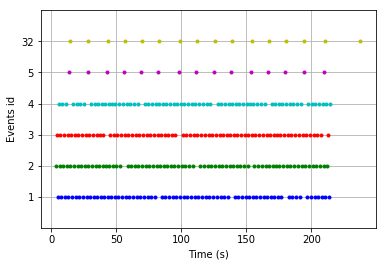

In [8]:
mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp);

## From raw to epochs

Define epochs parameters:

In [9]:
#event_id = dict(aud_l=1, aud_r=2)  # event trigger and conditions
event_id = {'aud_l': 1, 'aud_r': 2}  # event trigger and conditions
tmin = -0.1  # start of each epoch
tmax = 0.4  # end of each epoch
baseline = None  # no baseline as data were high passed

reject = dict(eeg=80e-6, eog=40e-6)

picks = mne.pick_types(raw.info, eeg=True, meg=True,
                       eog=True, stim=False, exclude='bads')

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline,
                    reject=reject, preload=True)  # with preload

print(epochs)

<Epochs  |  n_events : 110 (all good), tmin : -0.0998976065792 (s), tmax : 0.399590426317 (s), baseline : None, ~26.8 MB, data loaded,
 'aud_l': 54, 'aud_r': 56>


Look at the ERF and contrast between left and rigth response

In [10]:
evoked_left = epochs['aud_l'].average()
evoked_right = epochs['aud_r'].average()
evoked_contrast = mne.combine_evoked([evoked_left, evoked_right],
                                     [0.5, -0.5])

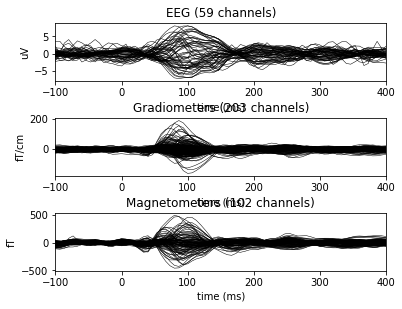

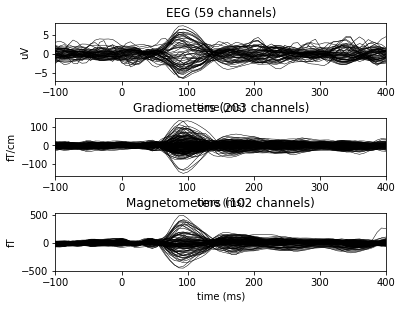

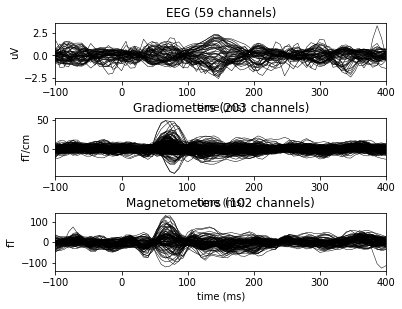

In [11]:
fig = evoked_left.plot()
fig = evoked_right.plot()
fig = evoked_contrast.plot()

Plot some topographies

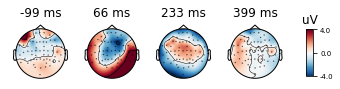

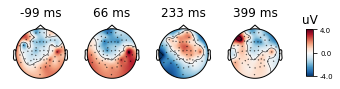

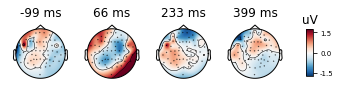

In [11]:
vmin, vmax = -4, 4
fig = evoked_left.plot_topomap(ch_type='eeg', contours=0, vmin=vmin, vmax=vmax)
fig = evoked_right.plot_topomap(ch_type='eeg', contours=0, vmin=vmin, vmax=vmax)
fig = evoked_contrast.plot_topomap(ch_type='eeg', contours=0, vmin=None, vmax=None)

## Now let's see if we can classify single trials with an SVM

To have a chance at 50% accuracy equalize epoch count in each condition

In [12]:
epochs.equalize_event_counts(event_id)
print(epochs)

<Epochs  |  n_events : 108 (all good), tmin : -0.0998976065792 (s), tmax : 0.399590426317 (s), baseline : None, ~26.4 MB, data loaded,
 'aud_l': 54, 'aud_r': 54>


A classifier takes as input an `x` and return `y` (0 or 1). Here x will be the data at one time point on all gradiometers (hence the term multivariate). We work with all sensors jointly and try to find a discriminative pattern between 2 conditions to predict the class.

For classification we will use the scikit-learn package (http://scikit-learn.org/) and MNE functions 

`
Reference:
Scikit-learn: Machine Learning in Python,
Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
`

In [14]:
import numpy as np
# make response vector
y = np.zeros(len(epochs.events), dtype=int)
y[epochs.events[:, 2] == 2] = 1

y.size

108

In [15]:
X = epochs.copy().pick_types(meg='grad').get_data()
X.shape

(108, 203, 76)

In [17]:
XX = X.reshape(108, -1)
XX.shape

(108, 15428)

In [18]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1e6)
cv = StratifiedKFold(n_splits=5, random_state=42)
scores = cross_val_score(clf, XX[2:], y[2:], cv=cv, scoring='roc_auc')
print(scores)
print('Accuracy = %s (std %s)' % (np.mean(scores), np.std(scores)))

[ 1.          0.88429752  0.87603306  0.87        0.83      ]
Accuracy = 0.892066115702 (std 0.0571073542954)


In [18]:
XX -= np.mean(XX, axis=0)
XX /= np.std(XX, axis=0)
y_pred = clf.fit(XX, y).predict(XX)
y_pred

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0])

In [19]:
y_pred = clf.fit(XX, y).predict(XX)
np.mean(y_pred == y)

1.0

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

cv = StratifiedShuffleSplit(n_splits=30, test_size=0.2, random_state=42)
scores = cross_val_score(clf, XX, y, cv=cv, scoring='roc_auc')
print('Accuracy = %s (std %s)' % (np.mean(scores), np.std(scores)))

Accuracy = 0.901377410468 (std 0.0595933419634)


(array([ 1.,  0.,  0.,  1.,  0.,  1.,  2.,  1.,  0.,  3.,  2.,  4.,  2.,
         0.,  3.,  2.,  4.,  1.,  1.,  2.]),
 array([ 0.75206612,  0.76446281,  0.7768595 ,  0.7892562 ,  0.80165289,
         0.81404959,  0.82644628,  0.83884298,  0.85123967,  0.86363636,
         0.87603306,  0.88842975,  0.90082645,  0.91322314,  0.92561983,
         0.93801653,  0.95041322,  0.96280992,  0.97520661,  0.98760331,  1.        ]),
 <a list of 20 Patch objects>)

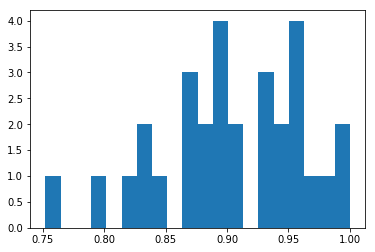

In [21]:
plt.hist(scores, bins=20)

In [20]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

from mne.decoding import TimeDecoding

# make response vector
y = np.zeros(len(epochs.events), dtype=int)
y[epochs.events[:, 2] == 2] = 1

cv = StratifiedKFold() # do a stratified cross-validation
td = TimeDecoding(cv=cv, scorer='roc_auc', n_jobs=1)

maximum AUC score: 0.796296296296


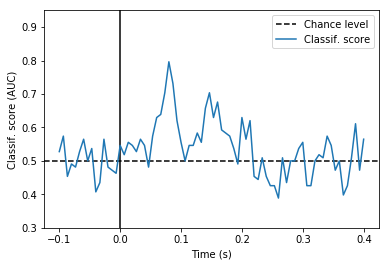

In [21]:
# Fit, score, and plot
ep = epochs.copy().pick_types(meg=False, eeg=True)
td.fit(ep, y=y)
scores = td.score(ep)
print('maximum AUC score:', max(scores))
td.plot(ymin=0.3, ymax=0.95);

maximum AUC score: 0.935185185185


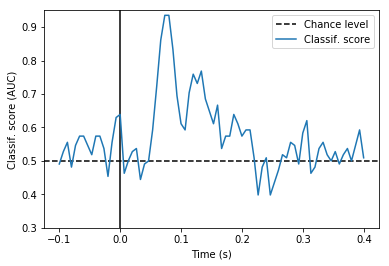

In [22]:
# Fit, score, and plot
ep = epochs.copy().pick_types(meg=True, eeg=False)
td.fit(ep, y=y)
scores = td.score(ep)
print('maximum AUC score:', max(scores))
td.plot(ymin=0.3, ymax=0.95);